# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [1]:
import numpy as np
from scipy import misc
from scipy.stats import multivariate_normal
from imp import reload
from labfuns import *
import random

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [9]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    
    # np.unique will return a list of unique class, and a list of count of each class
    classes , counts= np.unique(labels,return_counts=True) 
    Nclasses = np.size(classes)

    # TODO: compute the values of prior for each class!
    prior=[sum(W[labels==clas]) for clas in classes]
    prior = np.array(prior)
    # ==========================

    return prior

In [3]:
def cov(x): # x is n x d dimention vectors, returns d x d covariance matrix
    nrow=x.shape[0]
    col_mean = np.mean(x,axis=0) # axis = 1 will get the mean of rows
    u=np.array([col_mean,]*nrow) # repeat the col_mean vector n times
    x_dev=x-u
    covariance_matrix=np.mat(x_dev.T)*np.mat(x_dev)/nrow
    return covariance_matrix

In [43]:
# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)


def mlParams(X, labels, W=None): # return maximum likelihood parameters
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)
    
    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    # TODO: fill in the code to compute mu and sigma!
    # ==========================
    for idx, clas in enumerate(classes):
        clas_data=X[labels==clas]
        clas_weight=W[labels==clas]
        clas_count=sum(labels==clas)
        
        #calculate weighted average
        clas_mu=np.average(clas_data,weights=clas_weight.reshape(-1),axis=0) #reshape(-1) convert n Dim array to 1 D
        mu[idx,:]=clas_mu
        
        u=np.array([clas_mu,]*clas_count)
        dev=clas_data-u
        weighted_dev=np.zeros((dev.shape[0],dev.shape[1]))
        for i_row in range(dev.shape[0]):
            weighted_dev[i_row,:]=dev[i_row,:]*clas_weight[i_row]
        
        cov_matrix=np.mat(dev.T)*np.mat(weighted_dev)/sum(clas_weight)
        sigma[idx,:] = cov_matrix
        
    # ==========================
    return mu, sigma

# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    # Posterior Prob = likelihood * prior
    for i in xrange(Nclasses):
        clas_mu=mu[i]
        clas_sigma=sigma[i]
        multidim_norm=multivariate_normal(clas_mu,clas_sigma)
        clas_prior=prior[i]
        for j in xrange(Npts):
            x=X[j,:]
            likelihood=multidim_norm.pdf(x)
            logProb[i,j]=likelihood*clas_prior
    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

In [22]:
x=np.array([[90,60,90],[90,90,30],[60,60,60],[60,60,90],[30,30,30]])
labels=np.array([1,1,1,1,1])
we=np.array([0.2,0.2,0.2,0.2,0.2])
print computePrior(labels,we.reshape(5,1))
mu,sigma=mlParams(x,labels)
print mu
print sigma

[[ 1.]]
[[ 66.  60.  60.]]
[[[ 504.  360.  180.]
  [ 360.  360.    0.]
  [ 180.    0.  720.]]]


The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [12]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

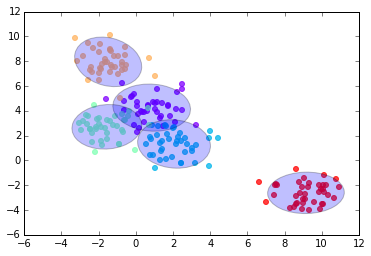

In [13]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [44]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 97.8
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 95.6
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 100
Trial: 60 Accuracy 97.8
Trial: 70 Accuracy 95.6
Trial: 80 Accuracy 97.8
Trial: 90 Accuracy 95.6
Final mean classification accuracy  96.7 with standard deviation 1.87


In [45]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 90.9
Trial: 10 Accuracy 89
Trial: 20 Accuracy 92.9
Trial: 30 Accuracy 91.6
Trial: 40 Accuracy 91.6
Trial: 50 Accuracy 89.6
Trial: 60 Accuracy 90.9
Trial: 70 Accuracy 89
Trial: 80 Accuracy 85.7
Trial: 90 Accuracy 89
Final mean classification accuracy  90.6 with standard deviation 2.26


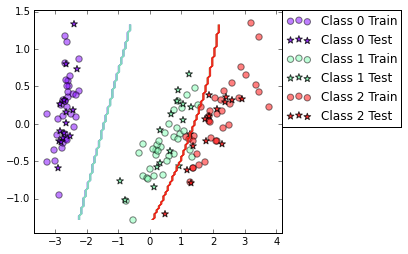

In [26]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Boosting functions to implement

The lab descriptions state what each function should do.

In [40]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def prediction_result(x,y):
    result=[]
    for class_pred,class_label in zip(x,y):
        if class_pred==class_label:
            result.append(1)
        else:
            result.append(0)
    return result
        
def alpha_sign(x,y):
    if x==y:
        return -1
    else:
        return 1

def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))
        
        #print wCur
        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # calculate wighted error, (wight vector*predictionError (0 if correct, 1 if incorrect)
        predictionError=[1 - x for x in prediction_result(vote,labels)]
        
        #print predictionError[40:49]
        error = sum(p*q for p,q in zip(wCur.reshape(-1),predictionError))
        if error ==0:
            error = 0.00000001
        alpha = (np.log(1-error)-np.log(error))/2
        
        #print error, alpha
        alphas.append(alpha) # you will need to append the new alpha
        #update weights
        for i_row in range(wCur.shape[0]):
            weight_change = np.e**(alpha*alpha_sign(vote[i_row],labels[i_row]))
            wCur[i_row,:] = wCur[i_row,:]*weight_change
        
        #print wCur[40:49]
        wCur=wCur/sum(wCur)
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)
    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))
        prediction_matrix = np.zeros((Npts,Ncomps))
        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================        

        for k in xrange(Ncomps):
            pred_clas = classifiers[k].classify(X)
            prediction_matrix [:,k] = pred_clas
        
        for i in xrange(Npts):
            for clas in xrange(Nclasses):
                clas_vote=0
                for k in xrange(Ncomps):
                    pred_clas = prediction_matrix [i,k]
                    if pred_clas == clas:
                        clas_vote += alphas[k]
                votes[i,clas]=clas_vote
            
        #print votes[::10,]
        # ==========================
        #print votes[0,:]
        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [28]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [46]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 93.3
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 95.6
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 95.6
Final mean classification accuracy  95 with standard deviation 2.88


In [49]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 89
Trial: 10 Accuracy 89
Trial: 20 Accuracy 92.9
Trial: 30 Accuracy 93.5
Trial: 40 Accuracy 92.2
Trial: 50 Accuracy 88.3
Trial: 60 Accuracy 92.9
Trial: 70 Accuracy 92.9
Trial: 80 Accuracy 87
Trial: 90 Accuracy 89.6
Final mean classification accuracy  91.3 with standard deviation 2.19


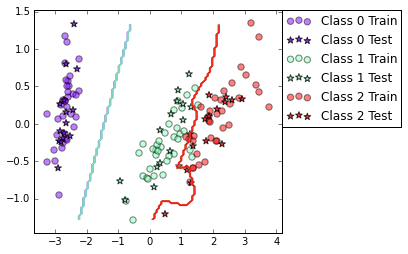

In [42]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [47]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [48]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 93.3
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.75


In [50]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4.05


In [51]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 87
Trial: 10 Accuracy 87.7
Trial: 20 Accuracy 86.4
Trial: 30 Accuracy 92.9
Trial: 40 Accuracy 85.1
Trial: 50 Accuracy 81.8
Trial: 60 Accuracy 86.4
Trial: 70 Accuracy 87.7
Trial: 80 Accuracy 86.4
Trial: 90 Accuracy 87
Final mean classification accuracy  86.7 with standard deviation 2.93


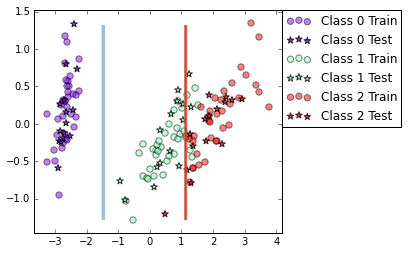

In [52]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

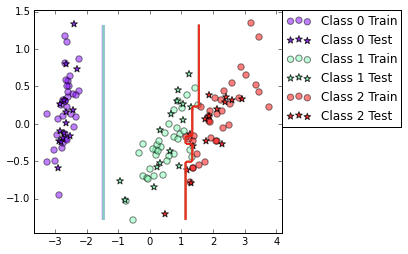

In [53]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [ ]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

In [55]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 73.3
Trial: 10 Accuracy 75.8
Trial: 20 Accuracy 70
Trial: 30 Accuracy 69.2
Trial: 40 Accuracy 71.7
Trial: 50 Accuracy 62.5
Trial: 60 Accuracy 71.7
Trial: 70 Accuracy 70
Trial: 80 Accuracy 70
Trial: 90 Accuracy 71.7
Final mean classification accuracy  71.2 with standard deviation 5.65


You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

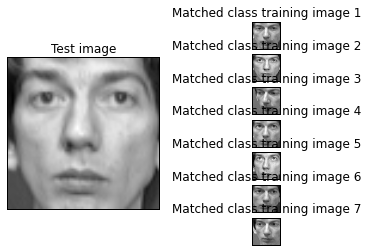

In [56]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])